In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json

# Read Data

In [275]:
north_india = pd.read_csv('./data/north-india.csv')
south_india = pd.read_csv('./data/south-india.csv')
metadata = pd.read_csv('./data/metadata.csv')
with open('output.json') as json_file:
    codebook = json.load(json_file)

## Draw from Google Sheets

In [276]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# Reference: https://developers.google.com/sheets/api/quickstart/python
def read_google_sheets(SPREADSHEET_ID, RANGE_NAME, HEADER_RANGE):
    creds = None
    # autogenerated
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                range=RANGE_NAME).execute()
    
    header = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                               range=HEADER_RANGE).execute()
    
    header_values = header.get('values', [])
    values = result.get('values', [])
    
    return values, header_values

SPREADSHEET_ID = '1AjynK9mMQTw58B_B8b_ZIip3fyUm-aoV7Pp21HziBb0'
RANGE_NAME = 'canto_codings!A2:AT'
HEADER_RANGE = 'canto_codings!A1:AT1'

data, header = read_google_sheets(SPREADSHEET_ID, RANGE_NAME, HEADER_RANGE)

canto_codings = pd.DataFrame(data, columns = header[0])

## Utility Functions

In [277]:
def find_canto_features(canto_coding_id):
    for i,row in canto_codings.iterrows():
        if(str(canto_coding_id) == row['canto_coding_id']):
            return row

In [278]:
def get_canto_metadata(canto_coding_id):
    for i, row in metadata.iterrows():
        if(str(canto_coding_id) == row['C-id']):
            return row

In [279]:
def get_display_code(line, binary_code):
    line = codebook['line_'+str(line)]
    for encoding in line:
        if encoding['code'] == str(binary_code):
            return encoding['display_code']

# Prepare Output Data Structure

In [280]:
columns = ["canto_coding_id", "culture", "lat", "lng"]

for i in range(37):
    columns.append("cv_"+str(i+1))
    
north_india_full = pd.DataFrame(columns=columns)
south_india_full = pd.DataFrame(columns=columns)

# Connect Everything

In [281]:
def main(input_matrix, output_matrix):
    for i, row in input_matrix.iterrows():
        canto_coding_id = row['canto_coding_id']
        culture = row['place']
        meta = get_canto_metadata(int(canto_coding_id))
        lat = meta['Local_lat']
        lng = meta['Local_long']
        canto = find_canto_features(canto_coding_id)
        canto_data = []
        for i in range(37):
            canto_data.append(get_display_code(i+1, canto["cv_"+str(i+1)]))
        new_row = pd.DataFrame([[
            canto_coding_id,
            culture,
            lat,
            lng,
            canto_data[0],
            canto_data[1],
            canto_data[2],
            canto_data[3],
            canto_data[4],
            canto_data[5],
            canto_data[6],
            canto_data[7],
            canto_data[8],
            canto_data[9],
            canto_data[10],
            canto_data[11],
            canto_data[12],
            canto_data[13],
            canto_data[14],
            canto_data[15],
            canto_data[16],
            canto_data[17],
            canto_data[18],
            canto_data[19],
            canto_data[20],
            canto_data[21],
            canto_data[22],
            canto_data[23],
            canto_data[24],
            canto_data[25],
            canto_data[26],
            canto_data[27],
            canto_data[28],
            canto_data[29],
            canto_data[30],
            canto_data[31],
            canto_data[32],
            canto_data[33],
            canto_data[34],
            canto_data[35],
            canto_data[36],
        ]], columns = columns)
        output_matrix = output_matrix.append(new_row)
    return output_matrix

In [282]:
north_india_full = main(north_india, north_india_full)

In [283]:
south_india_full = main(south_india, south_india_full)

In [284]:
north_india_full.to_csv('./data/north_india_full.csv', index=False)
south_india_full.to_csv('./data/south_india_full.csv', index=False)

In [285]:
region = []
for i in range(len(north_india_full)):
    region.append("North")
for i in range(len(south_india_full)):
    region.append("South")

frames = [north_india_full, south_india_full]
all_india_full = pd.concat(frames)
all_india_full["region"] = region
all_india_full.to_csv('./data/all_india_full.csv', index=False)

# Map Plot

In [550]:
#read from csv
all_india_full = pd.read_csv('./data/all_india_full.csv')

dropped = []
for i in range(37):
    dropped.append("cv_"+str(i+1))
dropped_2 = ["canto_coding_id"]
for item in dropped_2:
    dropped.append(item) 
places = all_india_full.drop(columns=dropped)
places['count'] = places.groupby('culture')['culture'].transform('count')

exist = []
lat = []
lng = []
count = []
region = []
locations = pd.DataFrame()
for i, row in places.iterrows():
    if row["culture"] not in exist:
        exist.append(row["culture"])
        lat.append(row["lat"])
        lng.append(row["lng"])
        count.append(row["count"]*150)
        region.append(row["region"])
    else:
        pass
locations["culture"] = exist
locations["lat"] = lat
locations["lng"] = lng
locations["count"] = count
locations["region"] = region

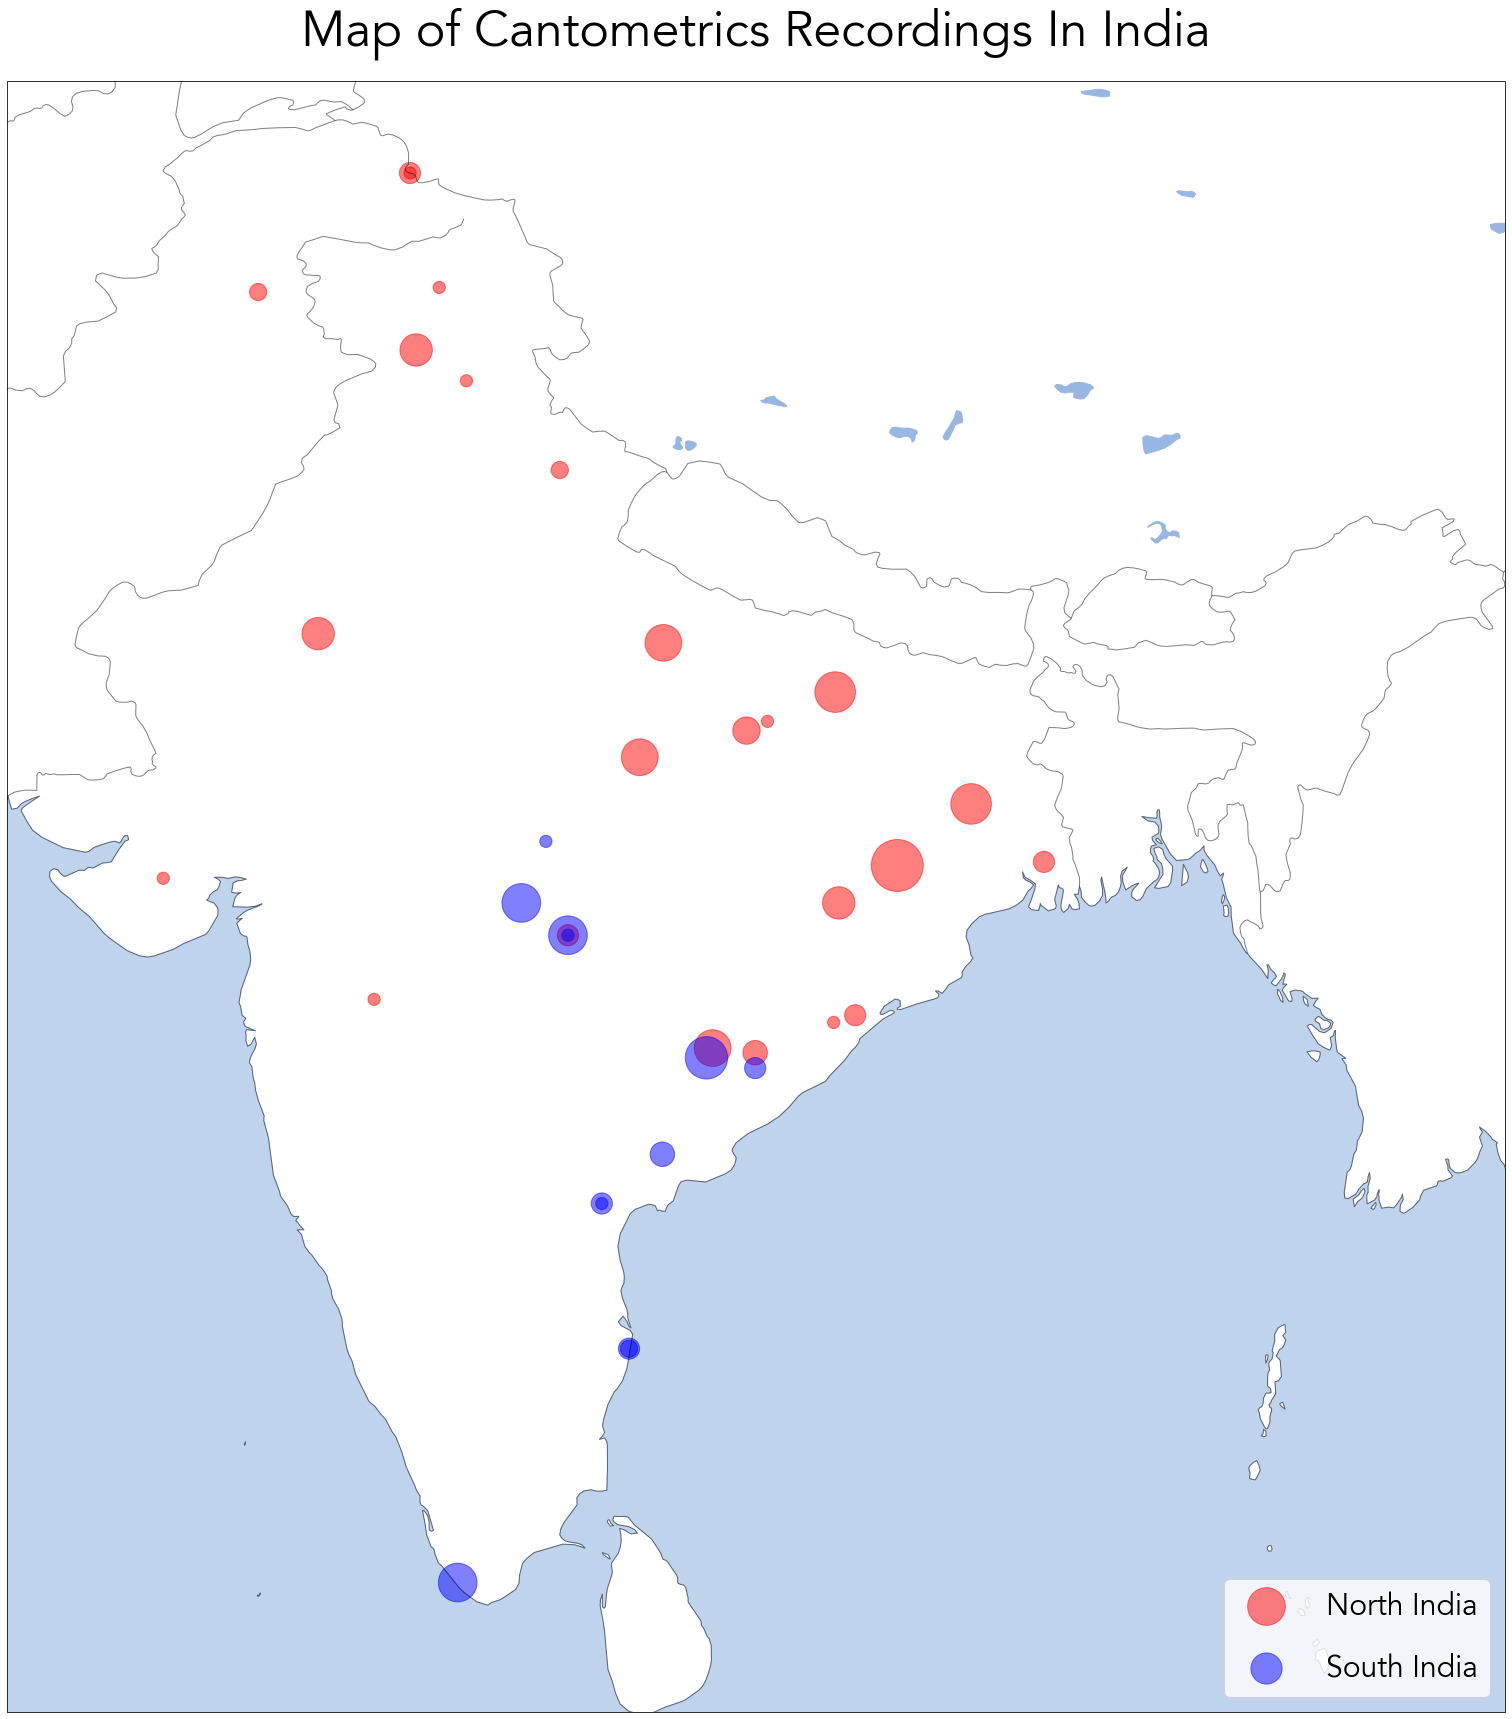

In [567]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cartopy.feature as cfeature
from random import random
%matplotlib inline

categories = np.unique(locations['region'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Avenir'})
plt.rcParams.update({'axes.titlepad': 36.0})
locations["Color"] = locations['region'].apply(lambda x: colordict[x])
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([68.14712,97.34466, 6, 37.090000])
north = locations.iloc[:24]
south = locations.iloc[24:]
ax.scatter(north.lng, north.lat, c="r", label="North India", s=north["count"], alpha=.5)
ax.scatter(south.lng, south.lat, c="b", label="South India", s=south["count"], alpha=.5)
south_label= tuple(np.array(south["culture"]))
ax.legend(loc="lower right", handletextpad=1.0, labelspacing=1.0, fontsize=30.0)
plt.title("Map of Cantometrics Recordings In India", fontsize=50, )
ax.coastlines(alpha=.5)
ax.add_feature(cfeature.BORDERS, alpha=.5)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.OCEAN, alpha=.6)
plt.savefig('./figs/map.png')

# World Map Plot

In [624]:
metadata = pd.read_csv('./data/metadata.csv')

<ipython-input-655-92ee62f0e79e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['count'] = metadata.groupby('Region')['C-id'].transform('count')


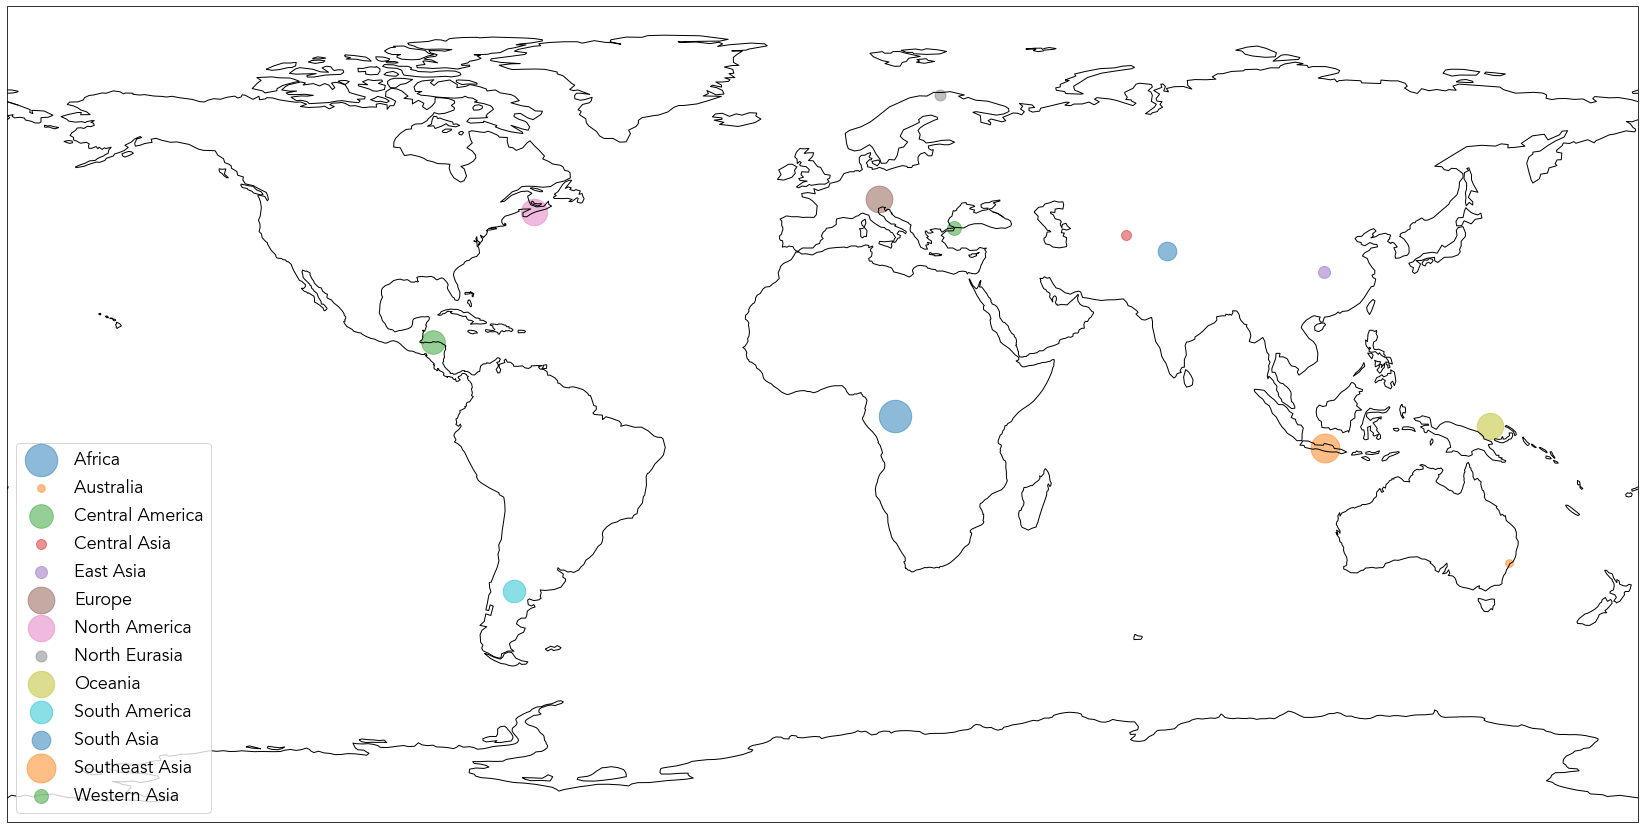

In [655]:
grouped_df = metadata.drop_duplicates(subset = ["Region"])
grouped_df['count'] = metadata.groupby('Region')['C-id'].transform('count')
grouped_df.to_csv('./data/grouped.csv')
grouped_df = pd.read_csv('./data/grouped.csv')
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Avenir'})
plt.rcParams.update({'axes.titlepad': 36.0})
categories = np.unique(locations['region'])
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_global()
for name, group in groups:
    ax.scatter(group['Local_long'], group['Local_lat'], s=group['count'], alpha=.5, label=name)
ax.coastlines()
ax.legend(loc="lower left")
plt.savefig("./figs/world.png")